# Settings and imports

#### Imports

In [1]:
import sys
sys.path.append('../my_polycomb_utils')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Some additional for plots
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

import cooler # Hi-C data processing
import networkx as nx # Network analysis
import pingouin as pg # Statistics

# Some utils for notebook
from tqdm import tqdm
from IPython.display import display

# Custom
from my_network_utils import draw_network, get_cliques

/home/nvaulin/tools/mambaforge/envs/hic-env/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


#### Preparing font

In [3]:
from pathlib import Path
from matplotlib import font_manager

# Downloaded in 01_Polycomb_loops_on_HiC_maps.ipynb
fpath=Path("../fonts/Montserrat-Regular.ttf")
fe = font_manager.FontEntry(fname=fpath, name='Montserrat')
font_manager.fontManager.ttflist.insert(0, fe) # or append is fine
font_manager.fontManager.addfont(fpath)

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Montserrat']

#### Settings

In [4]:
# Set-up suppression of some varnings
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# 01: Bulk polycomb network

**Figures in thesis:**
- `Figure 7`: (I) Whole 
network visualization, (II) Cliques sizes, (III) Clique visualization, (IV) Betweenness centrality

In [5]:
pcg_loops = pd.read_csv('../data/polycomb_loops.tsv', sep='\t')
pcg_loops = pcg_loops[['chrom1', 'start1', 'end1', 
                       'chrom2', 'start2', 'end2', 
                       'region1', 'region2', 'contact_pair', 
                       'dist_from_diag', 'pixel_size']].drop_duplicates()

chroms = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14',
       'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chrX'] + ['trans']

chroms_colors = {chroms[i] : plt.get_cmap('tab20b')((i+1) / len(chroms)) for i in range(len(chroms[:-1])) }
chroms_colors['trans'] = (0,0,0)

In [6]:
G = nx.from_pandas_edgelist(pcg_loops, 'region1', 'region2', edge_attr=['dist_from_diag'])
nx.set_node_attributes(G, pcg_loops.set_index('region1')['chrom1'].to_dict() | pcg_loops.set_index('region2')['chrom2'].to_dict(), 'Chromosome')

### _01 (I) Whole network visualization

In [7]:
print('-- General network characteristics --')

clusters = list(nx.connected_components(G))
clustering = list(nx.clustering(G).values())
degrees=[d for n, d in G.degree()]

print('Nodes N:', G.number_of_nodes())
print('Edges E:', G.number_of_edges())
print('Density rho:', nx.density(G))
print('Av. degree <k>:', np.mean(degrees))
print('N conected components NCC:', nx.number_connected_components(G))

diameter_in_components = []
for C in (G.subgraph(c).copy() for c in clusters):
    diameter_in_components.append(nx.diameter(C))

print('Max diameter d:',np.max(diameter_in_components))

number_of_nodes = []
for C in (G.subgraph(c).copy() for c in clusters):
    number_of_nodes.append(C.number_of_edges())
print('Max number of nodes :',np.max(number_of_nodes))

-- General network characteristics --
Nodes N: 206
Edges E: 647
Density rho: 0.030641723892967085
Av. degree <k>: 6.281553398058253
N conected components NCC: 9
Max diameter d: 9
Max number of nodes : 458


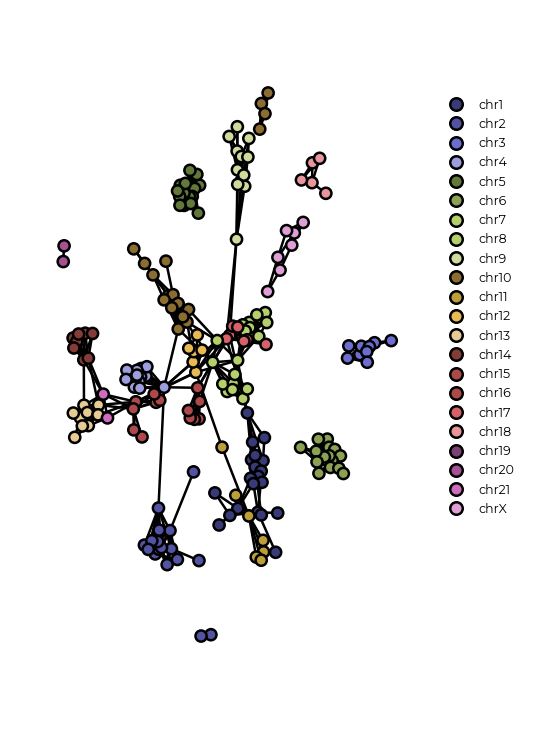

In [8]:
plt.figure(1, figsize=(3, 5), dpi=180)

pos = nx.spring_layout(G, seed = 420, k=0.15)
draw_network(G, 0.3, pos=pos, chroms_colors=chroms_colors)

### _01  (II) Cliques sizes

In [9]:
clq_sizes = pd.DataFrame(list(len(set(clq)) for clq in get_cliques(nx.find_cliques(G))), columns=['clq_size'])

In [10]:
print('Number of cliques:', len(clq_sizes))

Number of cliques: 157


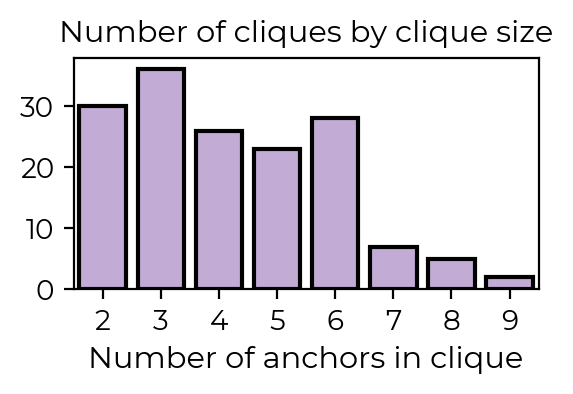

In [11]:
fig = plt.figure(figsize=(3, 1.5), dpi=200)

sns.barplot(clq_sizes.clq_size.value_counts().to_frame().reset_index(),
            x='clq_size', y='count',
            edgecolor="black", facecolor='#c2acd5',
            linewidth=1.5, 
           )

plt.ylabel('')
plt.xlabel('Number of anchors in clique', fontsize=11)
plt.title('Number of cliques by clique size', fontsize=11);

### _01 (III) Clique visualization

In [12]:
# Get cliques as subgraph
cliqs_G = nx.empty_graph()
cliqs_l = []
for clique in get_cliques(nx.find_cliques(G), 5):
    cliqs_l.append(G.subgraph(clique))
cliqs_G = nx.empty_graph()
for i, c in enumerate(cliqs_l):
    if 'chr6' in list(c.edges)[0][0]:
        cliqs_G = nx.compose(cliqs_G, G.subgraph(c))

In [13]:
# Get anchors of the cliques
clq_edges = [(eval(e[0])[1:], eval(e[1])[1:]) for e in list(cliqs_G.edges)]
loops = [(int(np.mean(c[0])), int(np.mean(c[1]))) for c in clq_edges]
anchors = sorted(list(set([ x for xs in loops for x in xs])))
anchors = [anc for anc in anchors if anc > 60_000_000]
print(anchors)

[84755000, 99585000, 100455000, 104945000, 108145000, 117265000, 133845000, 137485000]


In [14]:
RES = 200000

clr_plus = cooler.Cooler(f'../data/hc_plus.mcool::/resolutions/{RES}')
clr_minus = cooler.Cooler(f'../data/hc_minus.mcool::/resolutions/{RES}')

chroms_view = pd.DataFrame(data={
'chrom': clr_plus.chromsizes.index,
'start': [0] * len(clr_plus.chromsizes),
'end': clr_plus.chromsizes.values,
'name': clr_plus.chromsizes.index
})

start, end = min(anchors) - 10*RES, max(anchors) + 10*RES 
#start, end = 80_000_000, 156_000_000
region = ('chr6', start, end)

mtr_plus = (clr_plus.matrix(balance=True).fetch(region)[:])
mtr_minus = (clr_minus.matrix(balance=True).fetch(region)[:])
combined = np.zeros_like(mtr_plus)
combined[np.triu_indices_from(combined)] = mtr_plus[np.triu_indices_from(mtr_plus)]
combined[np.tril_indices_from(combined)] = 0

('chr6', 82755000, 139485000)


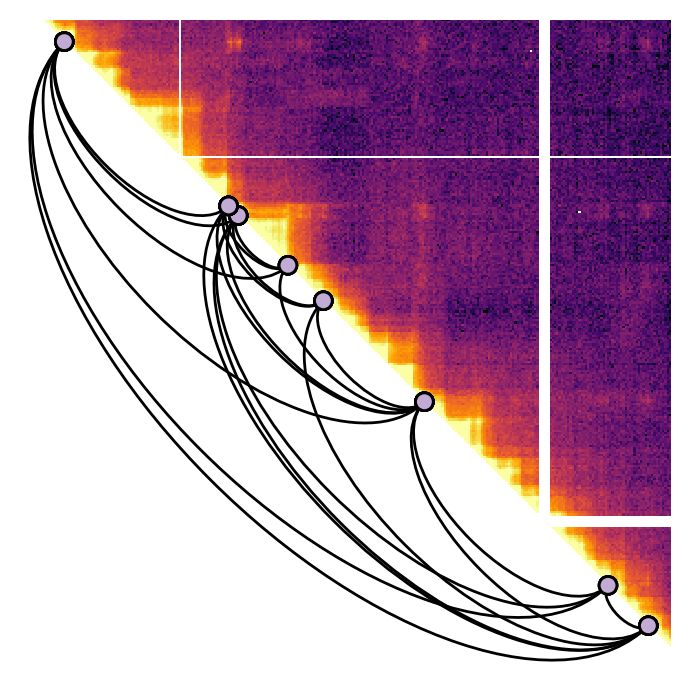

In [15]:
f, ax = plt.subplots(figsize=(6,4), dpi=200)

norm = LogNorm(vmax=0.02, vmin=0.0001)
im = ax.matshow(combined,
                norm=norm, cmap='inferno',
               extent=(start, end, end, start));

for loop in loops:
    arc_pos = np.mean(loop)
    if region[1] <= np.min(loop) <= np.max(loop) <= region[2]:
        width = np.sqrt(2) *(np.max(loop) - np.min(loop))
        pac = mpatches.Arc([arc_pos, arc_pos], width, width//2, angle=45, theta1=0, theta2=180)
        ax.add_patch(pac)

    for side in loop:
        x_pos = side
        ptch = plt.Circle((x_pos, x_pos), 4*RES, fc='#c2acd5', ec='k')
        ax.add_patch(ptch)

scale_u = 10
scale_l = 0
plt.xlim(region[1]-scale_u*RES, region[2]+scale_l*RES)
plt.ylim(region[2]+scale_u*RES, region[1]-scale_l*RES)
plt.tight_layout()
print(region)
plt.axis('off');

### _01 (IV) Betweenness centrality

In [16]:
centralities = pd.DataFrame(nx.betweenness_centrality(G).items(), 
                             columns=['anchor', 'centrality']).sort_values(by='centrality', 
                                                                           ascending=False)


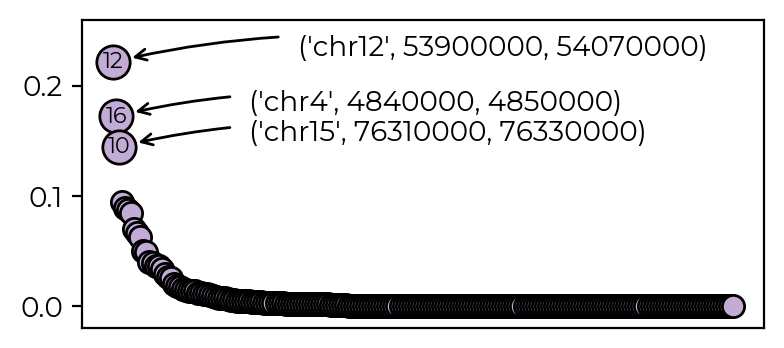

In [17]:
fig = plt.figure(figsize=(4.4, 2), dpi=200)


plt.gca().plot(centralities.anchor,
               centralities.centrality,
               'o', 
               markersize=8, color='#c2acd5', markeredgecolor ='black')
plt.gca().plot(centralities.head(3).anchor,
               centralities.head(3).centrality,
               'o', 
               markersize=12, color='#c2acd5', markeredgecolor ='black')


i=1
for idx, top_point in centralities.head(3).iterrows():
    plt.gca().text(top_point.anchor, top_point.centrality, G.degree(top_point.anchor), fontsize=8, ha='center', va='center')
    plt.gca().annotate(top_point.anchor, 
                xy=(top_point.anchor, top_point.centrality), 
                xytext=(45+i*16, top_point.centrality + 0.005 + i/2300),
                arrowprops=dict(arrowstyle="->",shrinkA=5, shrinkB=7,
                                connectionstyle="arc3,rad=.1"))
    i=0
    
plt.gca().set_xticks([])
plt.gca().set_xticks([], minor=True)

plt.ylim((-0.02, 0.26))
plt.xticks(rotation=45, ha='right');

# 02: Single-cell polycomb network

**Figures in thesis:**
- `Figure 8`: (I) Loops per cell, (II) Loops numbers and clusters sizes, (III) Top EN and IN cell subtypes

In [18]:
m3C_meta = pd.read_csv('../data/cells_fullmeta_m3C.tsv', sep='\t', index_col=0)
pcg_sc_loops = pd.read_csv('../data/polycomb_loops_in_single_cells.tsv', sep='\t',index_col=1).drop(columns='Unnamed: 0.1')
pcg_sc_loops = pcg_sc_loops[pcg_loops.sort_values(by='dist_from_diag').contact_pair.tolist()]
pcg_sc_loops.index.name = 'index'

### _02 (I) Loops per cell

In [19]:
pcg_sc_loops_count_anno = pcg_sc_loops.gt(0).sum(axis=1) \
                                      .to_frame() \
                                      .rename({0:'Count_polycomb_signal'}, axis=1) \
                                      .merge(m3C_meta[['Cool_name', 'MajorType', 'CellClass', 'Region']], 
                                             how='left', left_on='index', right_on='Cool_name') \
                                      .set_index('Cool_name')

,U-val,alternative,p-val,RBC,CLES
MWU,5357413.0,two-sided,3.773802e-14,-0.109623,0.554812


,U-val,alternative,p-val,RBC,CLES
MWU,7895513.0,two-sided,0.0,-0.660342,0.830171


,U-val,alternative,p-val,RBC,CLES
MWU,1660494.0,two-sided,1.731831e-305,0.565588,0.217206


Text(0.5, 0, 'Cell class')

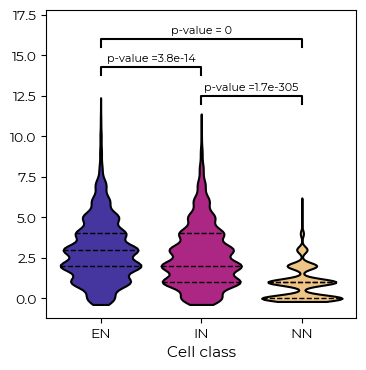

In [20]:
plt.figure(figsize=(4, 4), dpi=100)

ttset_res_ENIN = pg.mwu(pcg_sc_loops_count_anno.query('CellClass == "EN"').Count_polycomb_signal, 
                        pcg_sc_loops_count_anno.query('CellClass == "IN"').Count_polycomb_signal)
ttset_res_ENNN = pg.mwu(pcg_sc_loops_count_anno.query('CellClass == "EN"').Count_polycomb_signal, 
                        pcg_sc_loops_count_anno.query('CellClass == "NN"').Count_polycomb_signal)
ttset_res_NNIN = pg.mwu(pcg_sc_loops_count_anno.query('CellClass == "NN"').Count_polycomb_signal, 
                        pcg_sc_loops_count_anno.query('CellClass == "IN"').Count_polycomb_signal)
display(ttset_res_ENIN)
display(ttset_res_ENNN)
display(ttset_res_NNIN)
my_pal = {"EN": "#3924B1",
          "IN": "#C1118C",
          "NN": "#ffc875"} # "Set3_r"

ax = sns.violinplot(pcg_sc_loops_count_anno, x='CellClass', y='Count_polycomb_signal', 
                    palette=my_pal, bw=.2, cut=1, linewidth=1.5, inner="quartile",
                   );

for l in ax.lines:
    l.set_linestyle('--')
    l.set_linewidth(1)
    l.set_color('black')
plt.setp(ax.collections, edgecolor="k")


max_ = pcg_sc_loops_count_anno['Count_polycomb_signal'].max()
h = .5
text_h = .2

x1, x2 = 0, 1
y, col = max_ + h +  .3 + np.sum([x1, x2]), 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+text_h, f"p-value ={ttset_res_ENIN['p-val']['MWU']:.2g}", 
         ha='center', va='bottom', color=col, fontsize=8);

x1, x2 = 1, 2
y, col = max_ + h - .5, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+text_h, f"p-value ={ttset_res_NNIN['p-val']['MWU']:.2g}", 
         ha='center', va='bottom', color=col, fontsize=8);

x1, x2 = 0, 2
y, col = max_ + h + 3, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y+h+text_h, f"p-value = {ttset_res_ENNN['p-val']['MWU']:.2g}", 
         ha='center', va='bottom', color=col, fontsize=8);

ylims = plt.gca().get_ylim()
plt.ylim((ylims[0], ylims[1]+1))
plt.ylabel('')
plt.xlabel('Cell class', fontsize=11)

### _02 (II) Loops numbers and clusters sizes

In [21]:
cells = pcg_sc_loops.T.columns.tolist()

In [22]:
pcg_sc_loops_T = pcg_sc_loops.T.reset_index()
pcg_sc_loops_T[['region1', 'region2']] = pcg_sc_loops_T.apply(lambda x: eval(x['index']), axis=1, result_type='expand')
pcg_sc_loops_T = pcg_sc_loops_T[['region1', 'region2'] + cells]

In [23]:
networks = {}

for cell in tqdm(cells):
    selected_sc_loops = pcg_sc_loops_T.loc[pcg_sc_loops_T[cell]>0, ['region1', 'region2']]
    networks[cell] = nx.from_pandas_edgelist(selected_sc_loops, 'region1', 'region2')

100%|██████████| 8996/8996 [00:10<00:00, 823.48it/s] 


In [24]:
cols = ['Nodes', 'Edges', 'NCC', 'Density', 'MaxDiam', 'MaxClusterNodes', 'MaxClusterEdges']
network_metadata = pd.DataFrame(columns=cols, index=networks.keys())
for cell in tqdm(networks):
    G = networks[cell]
    
    clusters = list(nx.connected_components(G))

    if len(clusters) > 0:
        diameters_in_components = []
        nodes_in_components = []
        edges_in_components = []
        for C in (G.subgraph(c).copy() for c in clusters):
            diameters_in_components.append(nx.diameter(C))
            nodes_in_components.append(C.number_of_nodes())
            edges_in_components.append(C.number_of_edges())
        max_diam = np.max(diameters_in_components)  
        max_edges = np.max(edges_in_components)  
        max_nodes =  np.max(nodes_in_components)  
    else:
        max_diam, max_nodes, max_edges = 0, 0, 0
    #print('Max diameter:',np.max(diameter_in_components))

    network_metadata.loc[cell] = [G.number_of_nodes(),
                                  G.number_of_edges(),
                                  nx.number_connected_components(G),
                                  nx.density(G),
                                  max_diam, max_nodes, max_edges
                                 ]

100%|██████████| 8996/8996 [00:03<00:00, 2737.41it/s]


In [25]:
network_metadata = network_metadata.join(m3C_meta[['Cool_name', 'CellClass', 'MajorType']].set_index('Cool_name'), how='left')

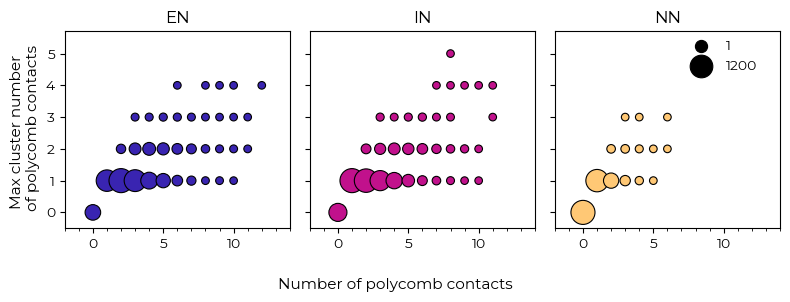

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=3, 
                         figsize=(8, 3), dpi=100,
                         sharey=True, layout='tight')

my_pal = {"EN": "#3924B1",
          "IN": "#C1118C",
          "NN": "#ffc875"
}

for j, cclass in enumerate(['EN', 'IN', 'NN']):
    dots_sizes = network_metadata.query('CellClass==@cclass').groupby(['Edges', 'MaxClusterEdges']).size()
    ax = sns.scatterplot(dots_sizes.reset_index().rename({0:'Size'}, axis=1), 
                         x='Edges', y='MaxClusterEdges',
                         size='Size', sizes=(30, 300),
                         linewidth=.8, edgecolor="black",
                         facecolor=my_pal[cclass],
                         ax=axes[j])

    axes[j].set_title(cclass, fontsize=12)
    axes[j].set_ylim(-0.5, 5.7)
    axes[j].set_xlim(-2, 14)
    axes[j].get_legend().remove()
    axes[j].set(xlabel=None)
    axes[j].set_xticks(np.arange(0, 14, 6))
    axes[j].set_xticks(np.arange(0, 14, 2), minor=True)
    axes[j].xaxis.set_major_locator(MultipleLocator(5))
    axes[j].xaxis.set_minor_locator(MultipleLocator(2))
    axes[j].xaxis.set_major_formatter('{x:.0f}')
    axes[j].xaxis.set_minor_locator(AutoMinorLocator())

    
all_dots_sizes = network_metadata.groupby(['Edges', 'MaxClusterEdges', 'CellClass']).size()
handles, lables = plt.gca().get_legend_handles_labels()
handles = [handles[0], handles[-1]]
lables = [np.int32(all_dots_sizes.min()),
          np.int32(np.ceil(all_dots_sizes.max() / 100) * 100)
         ]
          
for h, s in zip(handles, (30, 300)):
    h.set_markerfacecolor('k')


fig.legend(handles, lables, loc="upper left", bbox_to_anchor=(0.85, 0.89), frameon=False)

axes[0].set_ylabel('Max cluster number \n of polycomb contacts', fontsize=11)
fig.supxlabel('Number of polycomb contacts', fontsize=11);

### _02 (III) Top EN and IN cell subtypes

Text(0.5, 0, 'Polycomb cluster density')

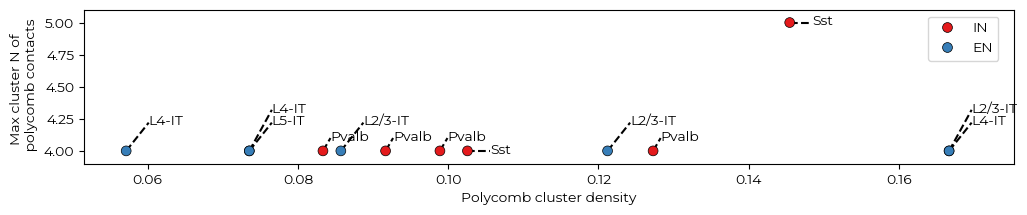

In [28]:
fig = plt.figure(figsize=(12, 2))
sns.scatterplot(network_metadata.query('MaxClusterEdges>=4'),
               x='Density',
               y='MaxClusterEdges',
               hue='CellClass',
               linewidth=.5, edgecolor="black",
                palette='Set1',
                s=50
               )


for i,(idx,row) in enumerate(network_metadata.sort_values(by='Density').query('MaxClusterEdges>=4').iterrows()):
    
    text_y = row["MaxClusterEdges"]
    text_x = row["Density"] 
        
    if row['MajorType'] == 'Pvalb':
        text_x = row["Density"] + 0.001
        text_y = row["MaxClusterEdges"] + 0.1
        
    if row['CellClass'] == 'EN':
        text_x = row["Density"] + 0.003
        text_y = row["MaxClusterEdges"] + 0.22 + i%2/10
        
    if row['MajorType'] == 'Sst':
        text_x = row["Density"] + 0.003
        text_y = row["MaxClusterEdges"]
        
    plt.plot([row["Density"], text_x],
             [row["MaxClusterEdges"], text_y], 
             zorder=-1,
            color='black',
            linestyle='--')
    plt.text(text_x,text_y-0.02, row["MajorType"])

plt.legend(loc="upper left", bbox_to_anchor=(.9,1))

plt.ylim(3.9, 5.1)

plt.ylabel('Max cluster N of \n polycomb contacts', fontsize=10)
plt.xlabel('Polycomb cluster density')


### _02 Cell types names

In [31]:
pd.set_option('display.max_rows', 160)

In [32]:
subtypes = m3C_meta[['SubTypeName', 'CellClass', 'Note']].reset_index(drop=True)
subtypes['SubTypeName'] = subtypes['SubTypeName'].apply(lambda x: x.rsplit('_', 1)[0])
subtypes = subtypes.drop_duplicates()

In [33]:
subtypes

,SubTypeName,CellClass,Note
0,ASC,NN,Astrocytes
1,MSN_D1,IN,D1 type medium spiny neurons
2,OPC,NN,Oligodendrocyte progenitor cell
3,ODC,NN,Oligodendrocytes
4,Bergmann-glia,NN,Astrocytes
5,Foxp2,IN,Neurons from BF/BN with gene Foxp2 hypomethylated
10,MGC,NN,Macro glia
21,SubCtx_Inh,IN,Subcortical cell types with huge heterogeneity
42,PC,NN,Perivascular Cell
56,VLMC,NN,Vascular Leptomeningeal Cell
